Microsoft Differential Privacy Whitepaper Collateral Notebooks Part 6
# Privacy Preserving Deep Learning for Medical Image Analysis

<img src="images/medicalimage.jpg" width=1000 />

The goal of this notebook is to demonstrate how to perform deep learning for medical image analysis in conjunction with differential privacy. This ensures that the contribution of the individuals (patients in this case) to the resulting machine learning model is masked out. Consequently it is not possible that information of individual patients may be leaked from the trained machine learning model.

We are using a public x-ray image dataset which includes cases with pneumonia and no finding (**normal** class). The flow of the demonstration is as follows:
1. Acquire and prepare x-ray images
2. Develop a Convolutional Neural Network (CNN) for image classification
3. Train a standard (non differentially private) model as a baseline
4. Use Differential Privacy to train a privacy preserving model
5. Compare the performance of both models

You can find the dataset under this location: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia. 
We have downloaded the dataset from above url and zipped the images files into the following structure:

<img src="images/chestimages.jpg" width = 300 />

This notebokk was developed and tested using an Azure ML NC24 GPU [compute instance](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-create-manage-compute-instance?tabs=python). 

## Setup
### Installs and imports

In [1]:
#%pip install opacus==0.9.1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import time
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from opacus import PrivacyEngine

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

from myutils import train, dptrain, plot_learning_curve, to_categorical, print_metrics, predict_loader

### Set global variables

In [13]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

# Source of compressed image dataset
ds_zip_source = 'data/chest-pat-2class.zip'
# Base directory to unzip the dataset
base_dir = '/home/azureuser/ml/chest-pat-2class/'

seed = 1

img_height, img_width, channels = 224, 224, 1
img_mean = 0.4818
img_std = 0.2357

cuda


## Acquire and prepare x-ray images
### Create dataset on local Compute Instance filesystem
Copy the dataset to the local filesystem to improve performance. This step is required only once per Compute Instance. Set `extract = True` for extraction.

In [3]:
extract = False

if extract == True:
    from zipfile import ZipFile
    
    with ZipFile(ds_zip_source, 'r') as zipObj:
        zipObj.extractall(base_dir)

In [4]:
torch.manual_seed(seed)
transform_train = transforms.Compose([transforms.Grayscale(),
                                transforms.Resize((img_height, img_width)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = (img_mean,), std = (img_std,))    
                               ])

transform_val = transforms.Compose([transforms.Grayscale(),
                                transforms.Resize((img_height, img_width)),
                                transforms.ToTensor(),   
                                transforms.Normalize(mean = (img_mean,), std = (img_std,))    
                               ])

training_dataset = datasets.ImageFolder(root = base_dir + 'train/', transform = transform_train)
validation_dataset = datasets.ImageFolder(root = base_dir + 'val/', transform = transform_val)
test_dataset = datasets.ImageFolder(root = base_dir + 'val/', transform = transform_val)

training_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 32, shuffle = True, drop_last=True)
validation_loader = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size = 32, shuffle = False, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = 100, shuffle = False)

### Show examples of both classes

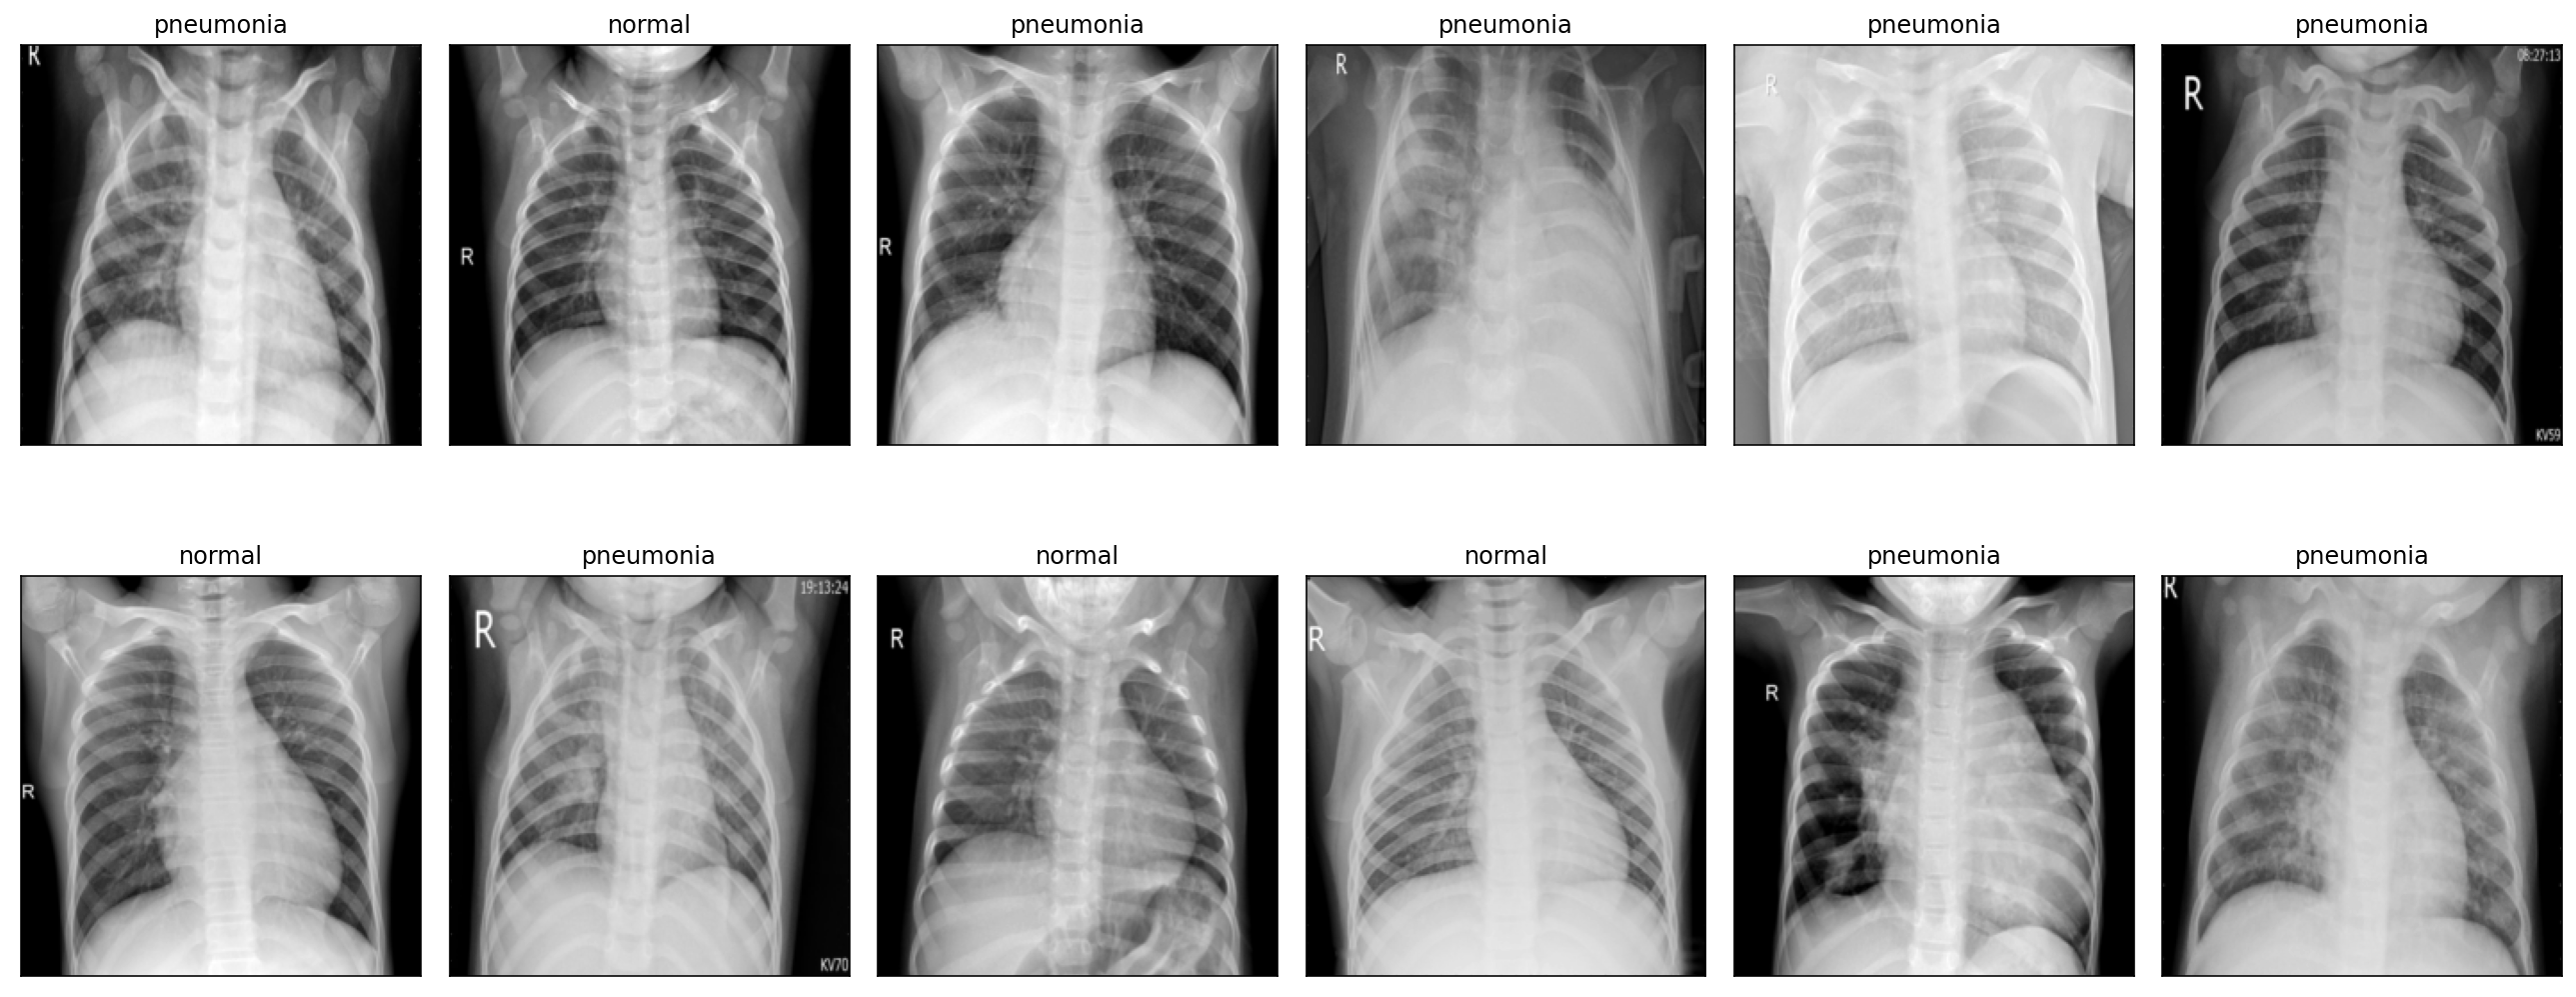

In [5]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0) # convert shape to WHC
    image = image * np.array (img_std,) + np.array(img_mean,) # revert normalization
    image = image.clip(0, 1)
    return image

dataiter = iter(training_loader)
images, labels = dataiter.next()

fig = plt.figure(figsize = (18, 8))
for idx in np.arange(12):
    ax = fig.add_subplot(2, 6, idx + 1, xticks = [], yticks = [])
    im = im_convert(images[idx]).reshape(img_height, img_width)
    plt.imshow(im , cmap = 'gray')
    ax.set_title(training_dataset.classes[labels[idx].item()])

plt.tight_layout()
plt.show()

## Develop a Convolutional Neural Network (CNN) for image classification

In [6]:
class Cnn(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 1,out_channels = 32, kernel_size = 3, stride = 1, padding=  1)
        self.conv2 = nn.Conv2d(in_channels = 32,out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv3 = nn.Conv2d(in_channels = 64,out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
             
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
                
        self.fc1 = nn.Linear(28*28*128, 256)
        self.fc2 = nn.Linear(256, 2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))  # 224 x 224 x 32
        x = F.max_pool2d(x, 2, 2)  # 112 x 112 x 32
        x = F.relu(self.conv2(x))  # 112 x 112 x 64
        x = F.max_pool2d(x, 2, 2)  # 56 x 56 x 64
        x = self.dropout1(x)
        x = F.relu(self.conv3(x))  # 56 x 56 x 128
        x = F.max_pool2d(x, 2, 2)  # 28 x 28 x 128
        x = self.dropout2(x)       
        x = x.view(-1, 28*28*128) # 100.352
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

The following neural network architecture is used for training the standard (non-private) and differentailly private image classification model (to be adjusted to above architecture).

<img src="images/cnnframe.png" width=1200 />

## Train a standard (non differentially private) model as a baseline

In [7]:
model = Cnn().to(device)

torch.manual_seed(seed)
history = train(model = model,
                device=device,
                optimizer = torch.optim.Adam(model.parameters(), lr = 0.0007),
                loss_fn = nn.CrossEntropyLoss(),
                train_dl = training_loader,
                val_dl = validation_loader,
                epochs = 15)

train() called: model=Cnn, opt=Adam(lr=0.000700), epochs=15, device=cuda

Epoch   1/ 15, train loss:  0.29, train acc:  0.90, val loss:  0.15, val acc:  0.95
Epoch   2/ 15, train loss:  0.10, train acc:  0.96, val loss:  0.13, val acc:  0.95
Epoch   3/ 15, train loss:  0.08, train acc:  0.97, val loss:  0.08, val acc:  0.97
Epoch   4/ 15, train loss:  0.06, train acc:  0.98, val loss:  0.07, val acc:  0.96
Epoch   5/ 15, train loss:  0.04, train acc:  0.98, val loss:  0.05, val acc:  0.98
Epoch   6/ 15, train loss:  0.03, train acc:  0.99, val loss:  0.05, val acc:  0.98
Epoch   7/ 15, train loss:  0.02, train acc:  0.99, val loss:  0.05, val acc:  0.98
Epoch   8/ 15, train loss:  0.02, train acc:  0.99, val loss:  0.05, val acc:  0.98
Epoch   9/ 15, train loss:  0.02, train acc:  0.99, val loss:  0.10, val acc:  0.97
Epoch  10/ 15, train loss:  0.01, train acc:  1.00, val loss:  0.10, val acc:  0.97
Epoch  11/ 15, train loss:  0.02, train acc:  0.99, val loss:  0.05, val acc:  0.98
Ep

### Review training progress

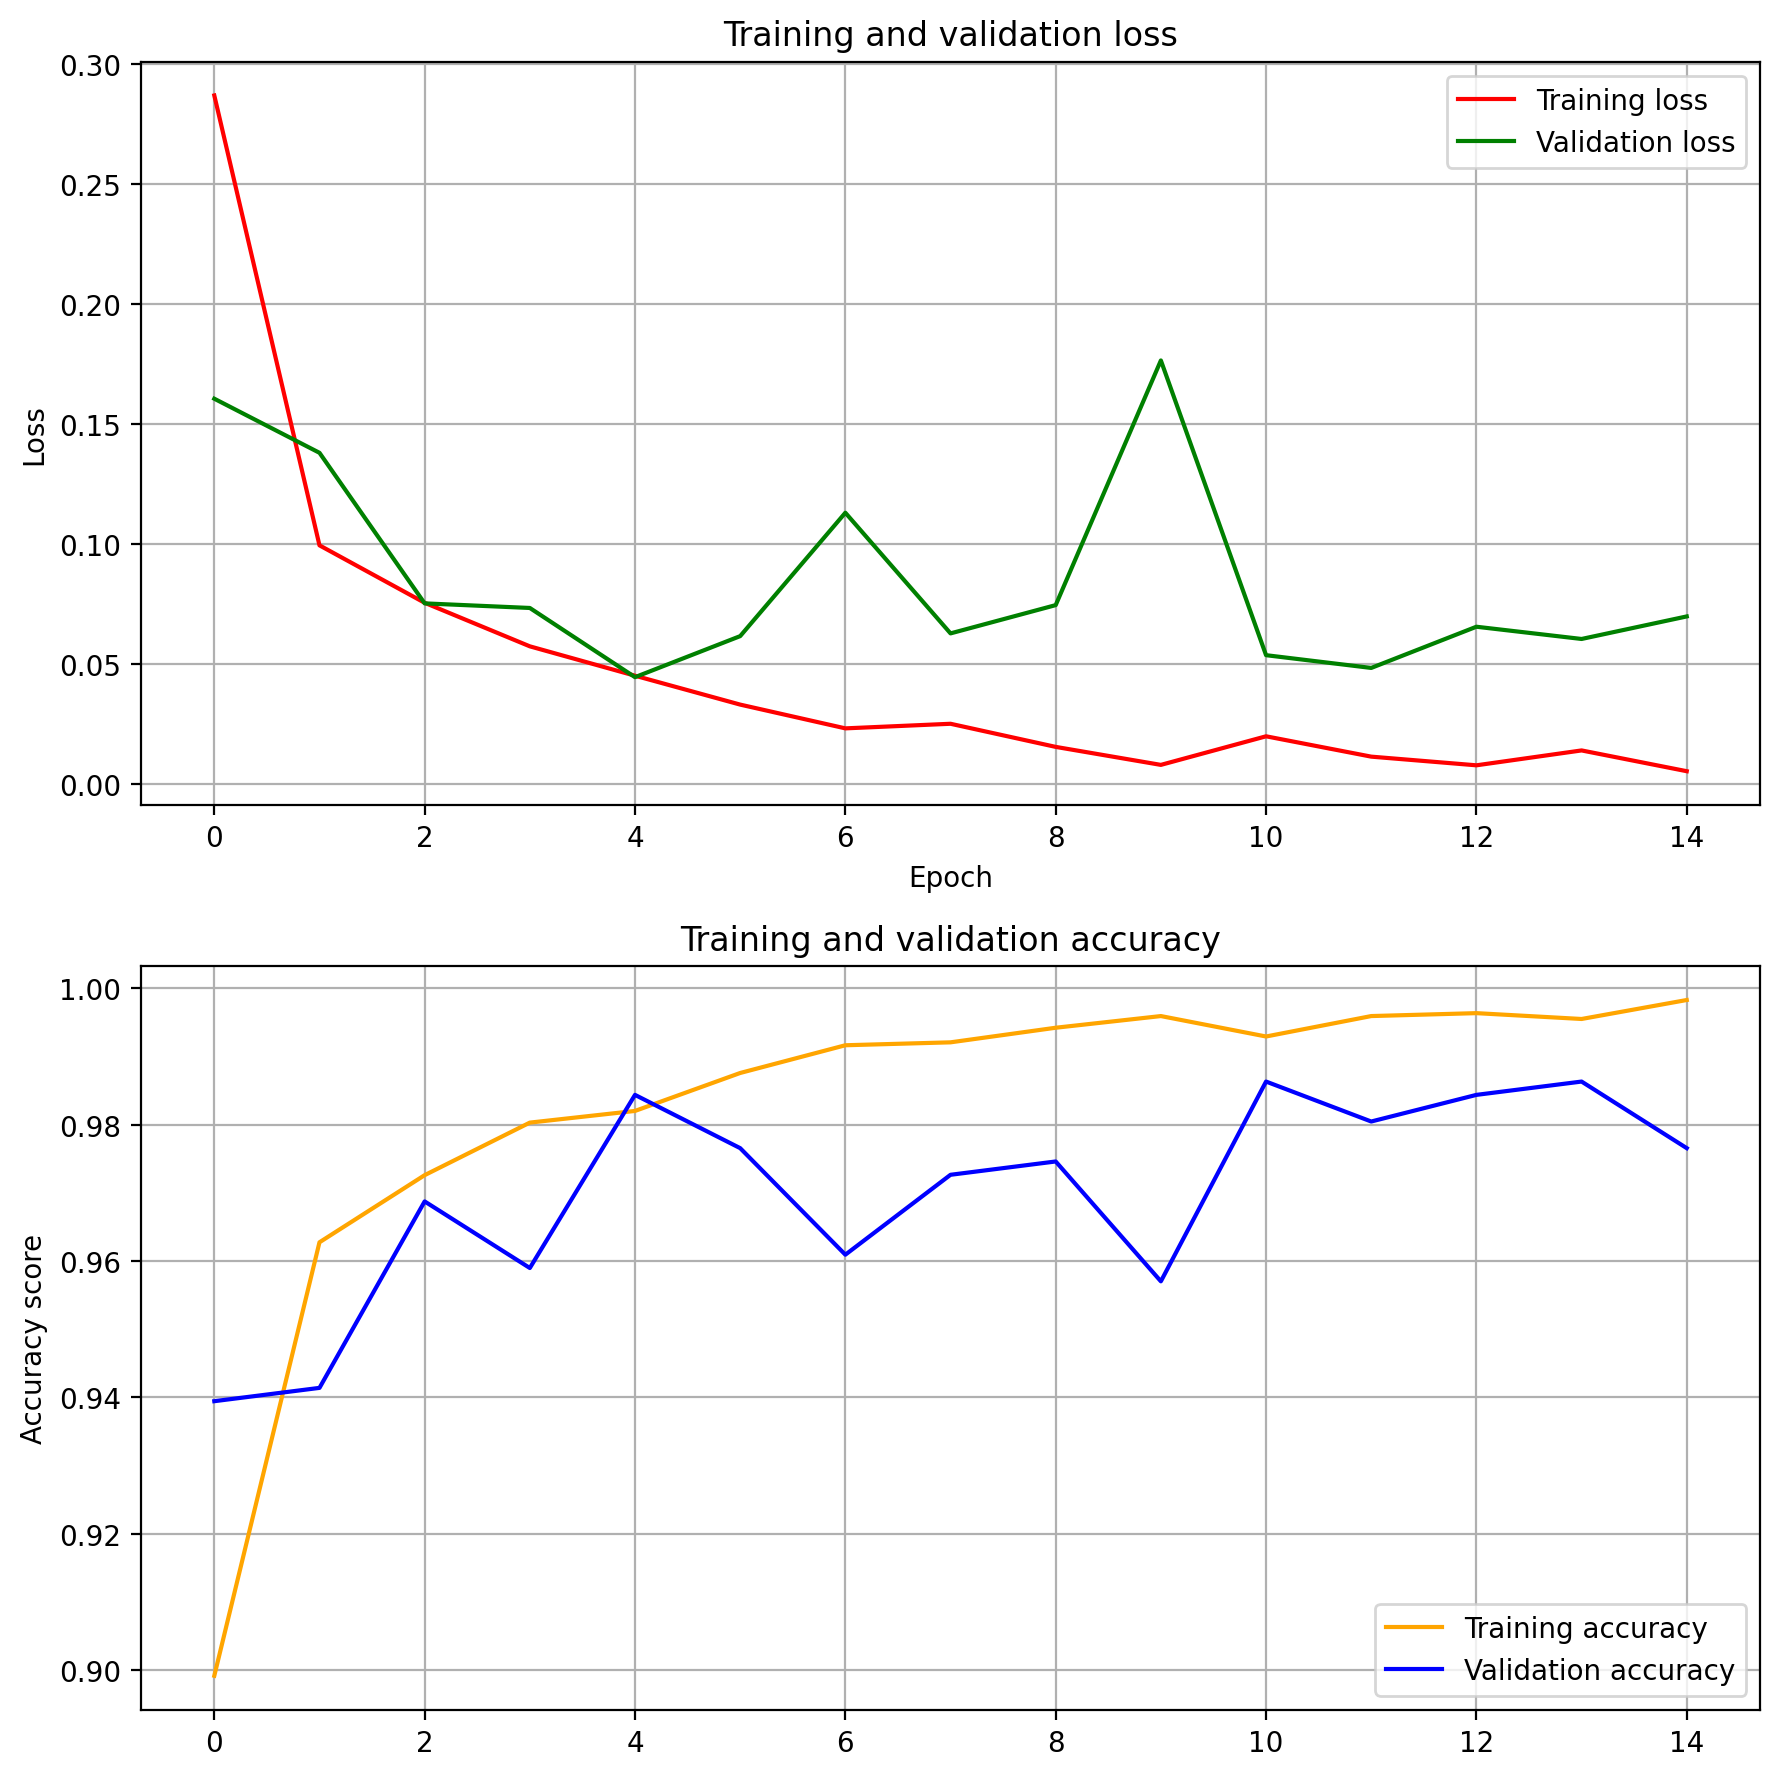

In [9]:
plot_learning_curve(history)

In [10]:
torch.save(model, 'models/pneumonia-nonpriv.pth')

### Evaluate model based on test set

In [11]:
model = torch.load('models/pneumonia-nonpriv.pth')

In [12]:
y_true, y_pred, y_probs = predict_loader(model, test_loader, device)

y_true = y_true.cpu()
y_pred = y_pred.cpu()
y_probs = y_probs.cpu()

y_true_oh = to_categorical(y_true, num_classes = 2)
y_pred_oh = to_categorical(y_pred, num_classes = 2)

print_metrics(y_true_oh, y_pred_oh, y_probs, test_dataset.classes)

              precision    recall  f1-score   support

      normal       1.00      0.91      0.95       134
   pneumonia       0.97      1.00      0.98       385

   micro avg       0.98      0.98      0.98       519
   macro avg       0.98      0.96      0.97       519
weighted avg       0.98      0.98      0.98       519
 samples avg       0.98      0.98      0.98       519

Accuracy score: 0.977  ---  ROC AUC score: 0.999


## Use Differential Privacy to train a privacy preserving model
The following parameters need to be considered in the training process:

* Noise parameter `noise_multiplier` conrols the amount of noise is added to the gradients before they are applied to the optimizer. Higher values improve the privacy level but are more challenging for the training process and therefore impact accuracy.
* Gradient clipping `l2_norm_clip` limits the sensitivity of the optimizer to individual training points. Therefore, the risk that the model memorizes individual data points is reduced.
* Minibatch size `batch_size` is the usual amout of samples used per update of the weights during training. This applies to all neural network based trainings and is not specific to differential privacy.
* Microbatch size `num_microbatches` 

The effect of the noise parameter `noise_multiplier` and gradient clipping `l2_norm_clip` values on adjusting the gradients during the differential private training process are shown in the following illustration: 

<img src="images/dp-deep-learning.png" width=800 />

Based on the illustration by Neeraj Rajkumar Parmaar ([Differential Privacy in Deep Learning](https://towardsdatascience.com/differential-privacy-in-deep-learning-cf9cc3591d28))


In [8]:
len(training_loader.dataset.samples)

4697

In [9]:
model = Cnn().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0007)

privacy_engine = PrivacyEngine(
    model,
    batch_size = 32,
    sample_size = len(training_loader.dataset),      
    alphas = [1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
    noise_multiplier = 0.65,
    max_grad_norm = 2.0)

privacy_engine.attach(optimizer)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/opacus/privacy_engine.py:111: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "


In [10]:
torch.manual_seed(0)
history = dptrain(model = model, 
                device=device,
                optimizer = optimizer,
                loss_fn = nn.CrossEntropyLoss(),
                train_dl = training_loader,
                val_dl = validation_loader,
                epochs = 15,
                target_delta=1/5000)

train() called: model=Cnn, opt=Adam(lr=0.000700), epochs=15, device=cuda

Epoch   1/ 15, train loss:  1.09, train acc:  0.74, val loss:  0.88, val acc:  0.74 - epsilon:  3.18, best alpha:  4.10
Epoch   2/ 15, train loss:  1.04, train acc:  0.74, val loss:  0.82, val acc:  0.74 - epsilon:  3.54, best alpha:  3.90
Epoch   3/ 15, train loss:  0.88, train acc:  0.75, val loss:  0.41, val acc:  0.80 - epsilon:  3.83, best alpha:  3.80
Epoch   4/ 15, train loss:  0.56, train acc:  0.81, val loss:  0.37, val acc:  0.87 - epsilon:  4.08, best alpha:  3.70
Epoch   5/ 15, train loss:  0.40, train acc:  0.88, val loss:  0.25, val acc:  0.90 - epsilon:  4.31, best alpha:  3.60
Epoch   6/ 15, train loss:  0.39, train acc:  0.90, val loss:  0.26, val acc:  0.91 - epsilon:  4.52, best alpha:  3.60
Epoch   7/ 15, train loss:  0.43, train acc:  0.90, val loss:  0.28, val acc:  0.91 - epsilon:  4.72, best alpha:  3.50
Epoch   8/ 15, train loss:  0.40, train acc:  0.91, val loss:  0.28, val acc:  0.91 - 

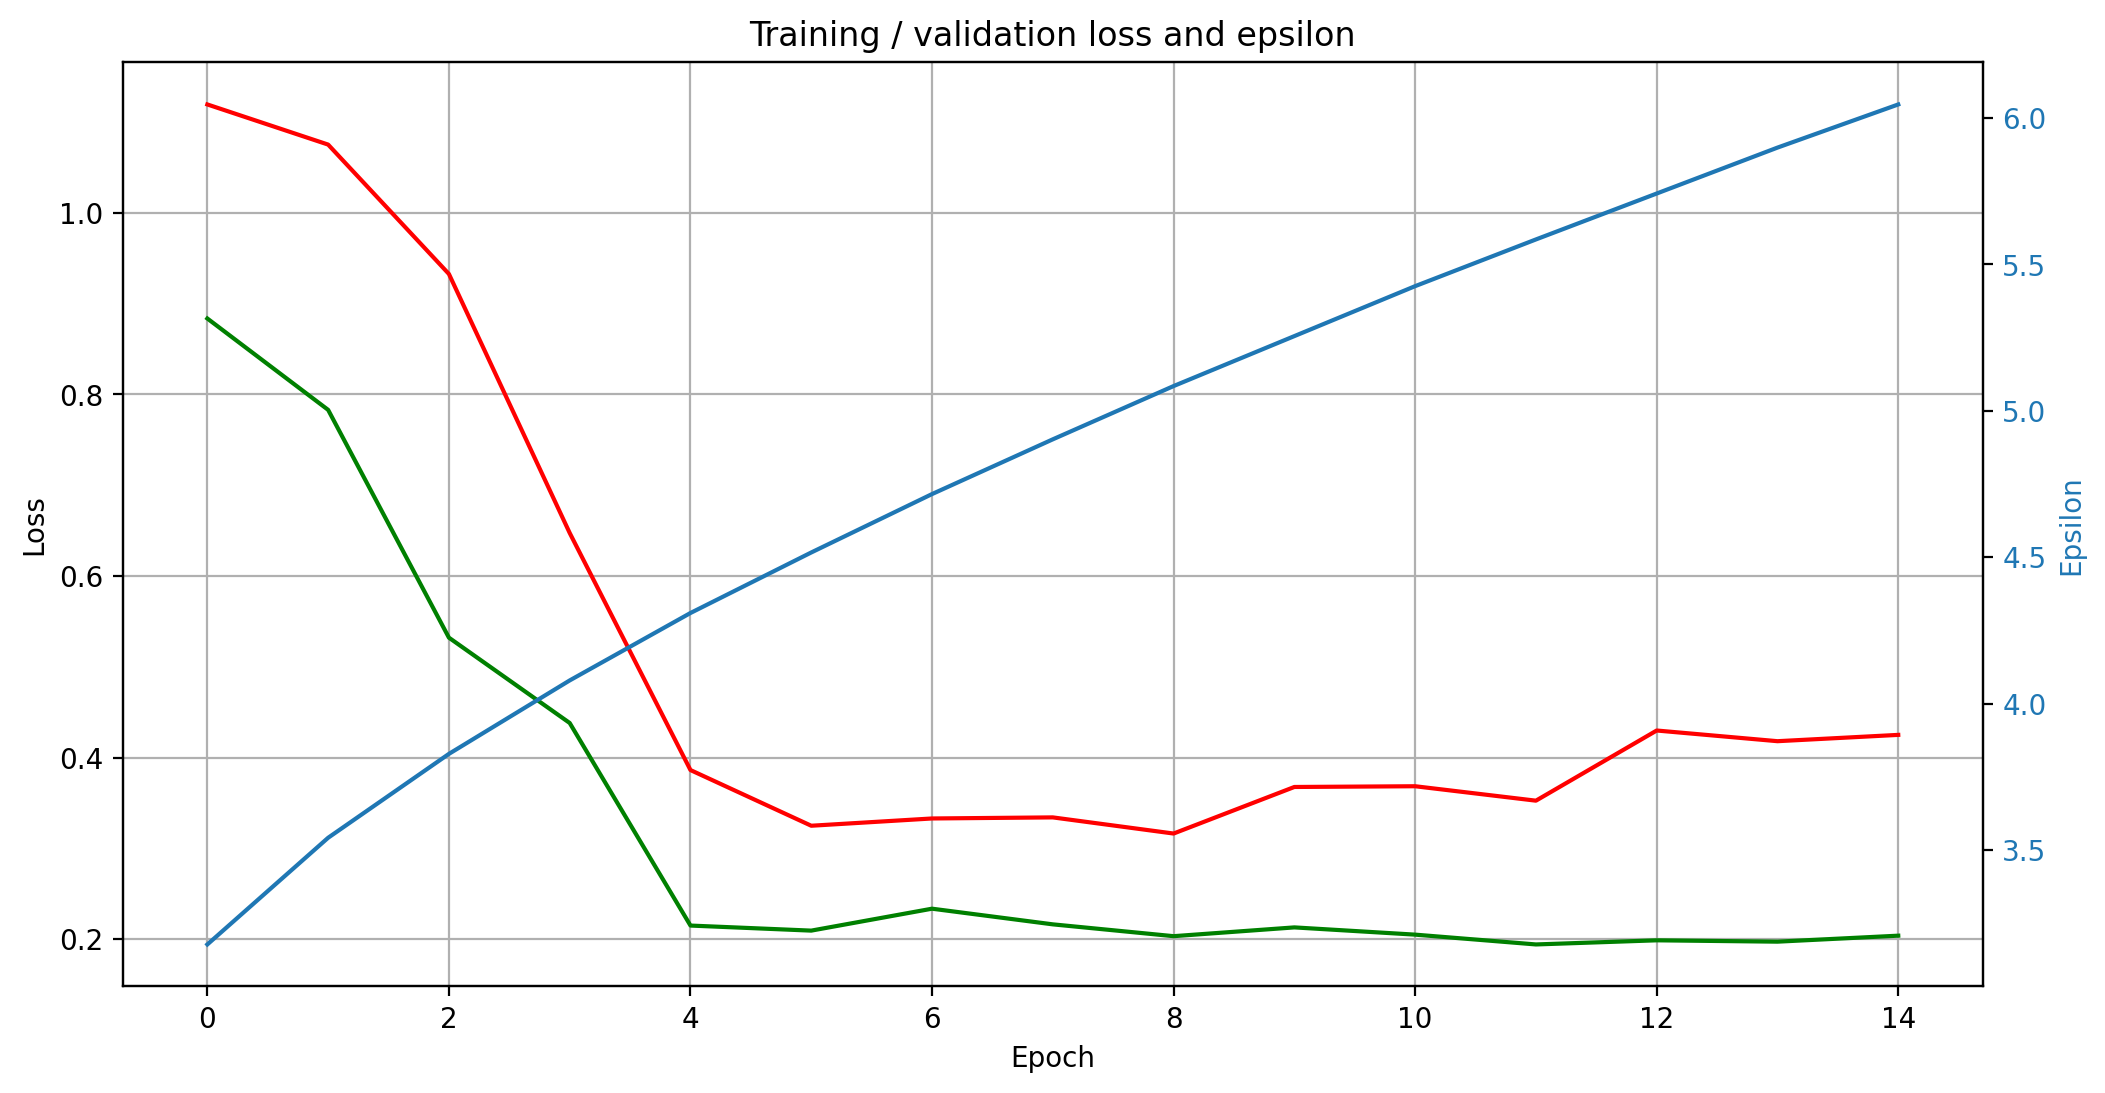

In [16]:
epochs = range(1, len(history['acc']) + 1)

fig, ax1 = plt.subplots(figsize=(12, 6))

plt.plot(history['loss'], 'red', label='Training loss')
plt.plot(history['val_loss'], 'green', label='Validation loss')
plt.title('Training / validation loss and epsilon')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Epsilon', color=color)
ax2.plot(history['epsilon'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

<Figure size 640x480 with 0 Axes>

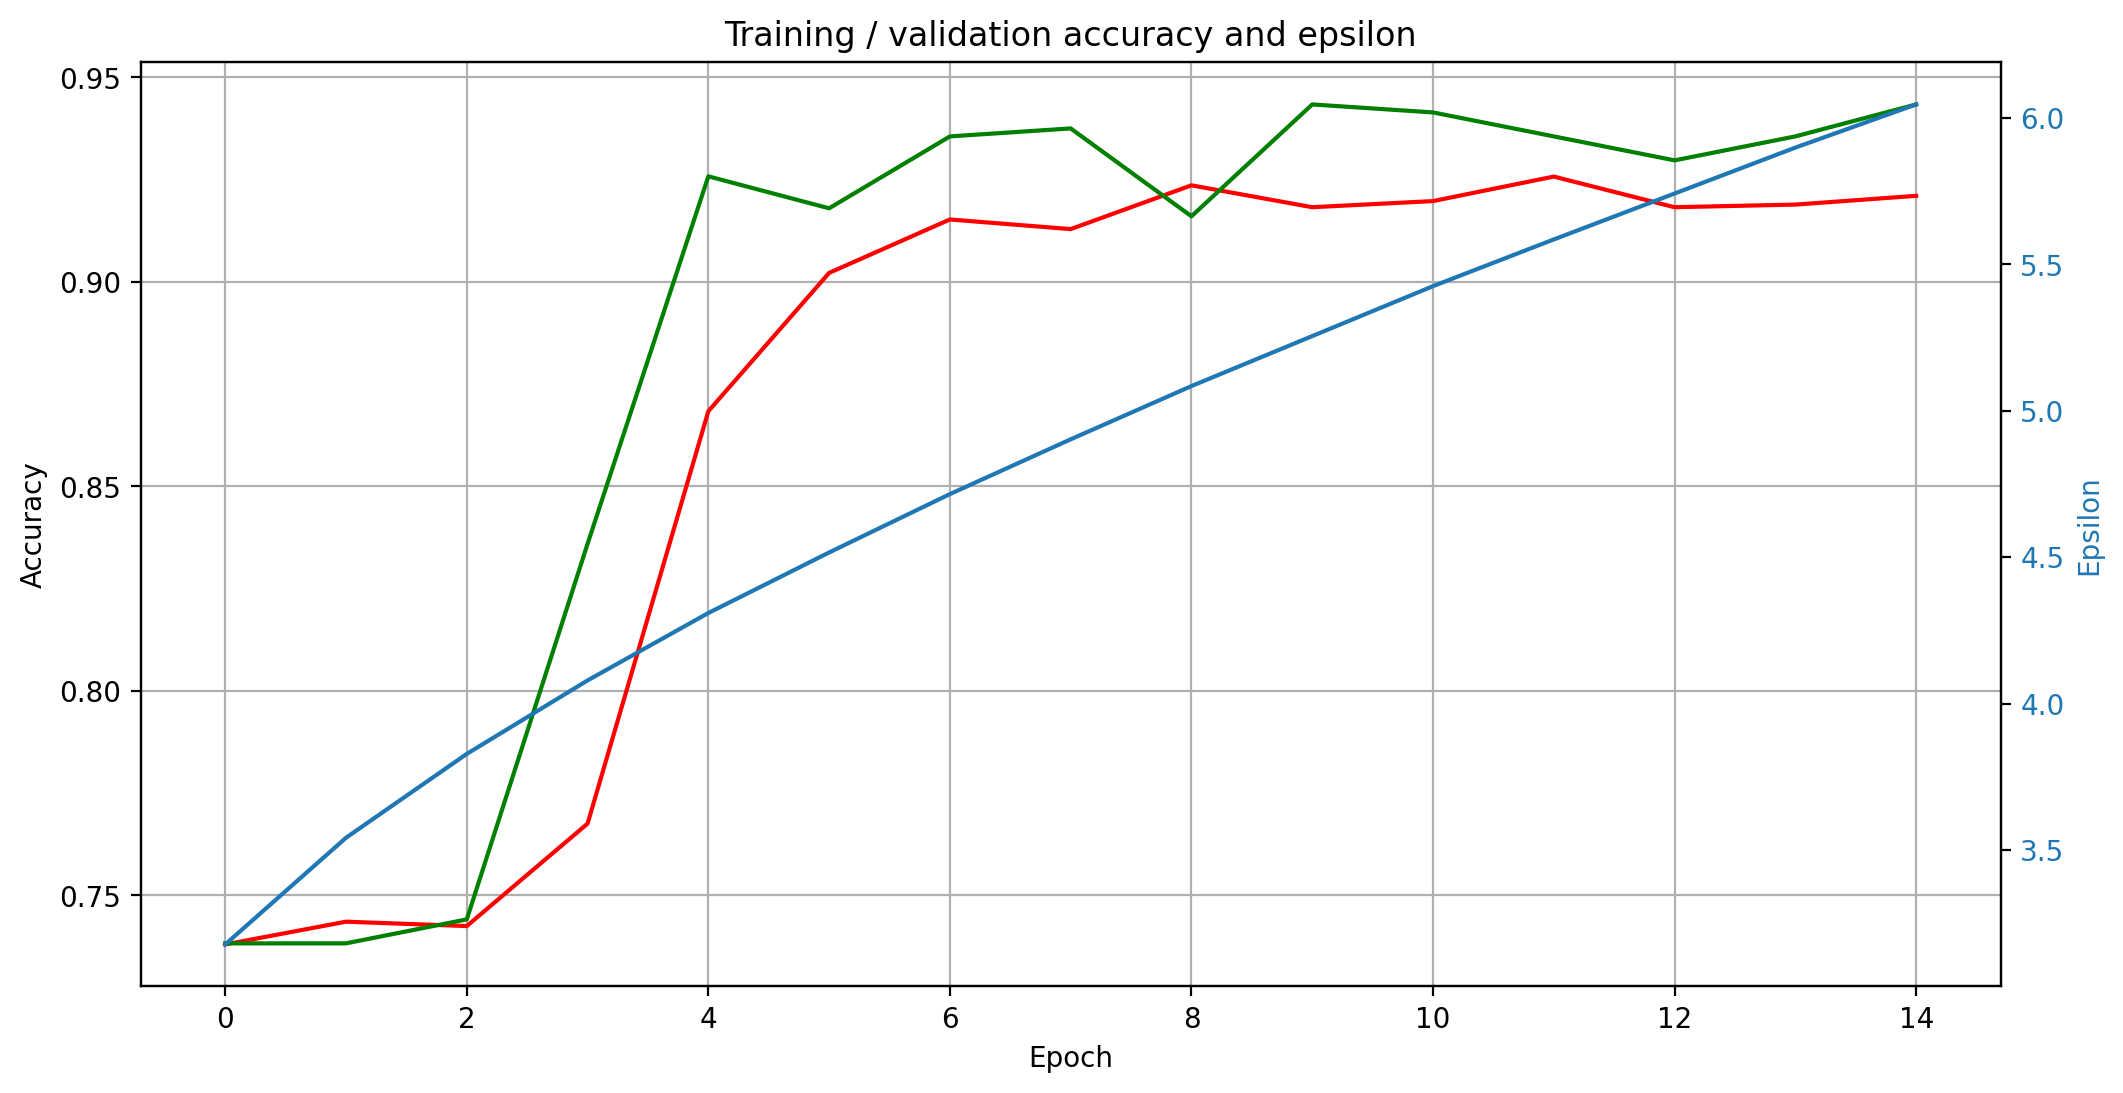

In [17]:
plt.clf()

epochs = range(1, len(history['acc']) + 1)

fig, ax1 = plt.subplots(figsize=(12, 6))

plt.plot(history['acc'], 'red', label='Training loss')
plt.plot(history['val_acc'], 'green', label='Validation loss')
plt.title('Training / validation accuracy and epsilon')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Epsilon', color=color)
ax2.plot(history['epsilon'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

### Option to save / load the model

In [18]:
torch.save(model, 'models/pneumonia-dp.pth')
model = torch.load('models/pneumonia-dp.pth')

### Evaluate accuracy on test set

In [19]:
y_true, y_pred, y_probs = predict_loader(model, test_loader, device)

y_true = y_true.cpu()
y_pred = y_pred.cpu()
y_probs = y_probs.cpu()

y_true_oh = to_categorical(y_true, num_classes = 2)
y_pred_oh = to_categorical(y_pred, num_classes = 2)

print_metrics(y_true_oh, y_pred_oh, y_probs, test_dataset.classes)

              precision    recall  f1-score   support

      normal       0.90      0.88      0.89       134
   pneumonia       0.96      0.97      0.96       385

   micro avg       0.94      0.94      0.94       519
   macro avg       0.93      0.92      0.93       519
weighted avg       0.94      0.94      0.94       519
 samples avg       0.94      0.94      0.94       519

Accuracy score: 0.944  ---  ROC AUC score: 0.979


## Compare the performance of both models

In [20]:
# Get y_true from testloader and predicted propabilities from non-private model:
np_model = model = torch.load('models/pneumonia-nonpriv.pth')
y_true, _, y_probs_np = predict_loader(np_model, test_loader, device)
y_true = y_true.cpu()
y_true_oh = to_categorical(y_true, num_classes = 2)
y_probs_np = y_probs_np.cpu()

# Get predicted propabilities from DP model:
dp_model = model = torch.load('models/pneumonia-dp.pth')
_, _, y_probs_dp = predict_loader(dp_model, test_loader, device)
y_probs_dp = y_probs_dp.cpu()

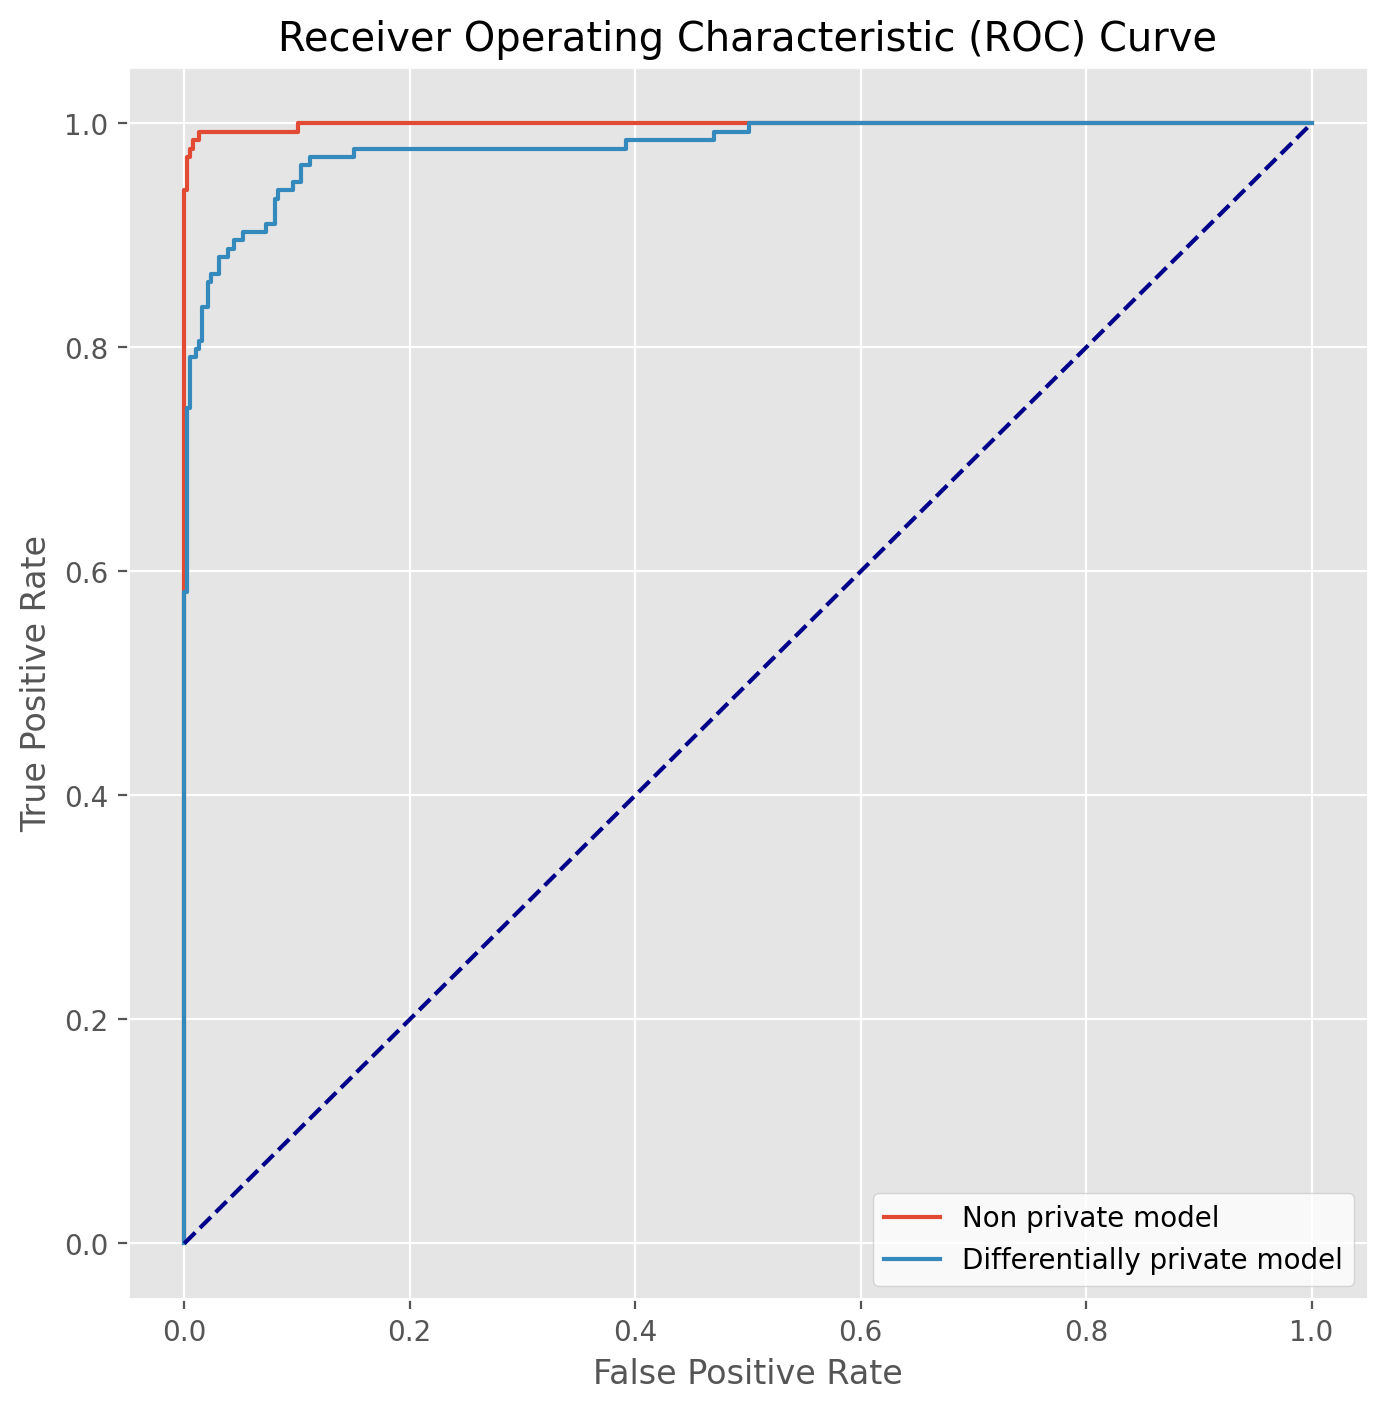

In [21]:
np_fpr, np_tpr, np_thresholds = roc_curve(y_true_oh[:,0], y_probs_np[:,0])
dp_fpr, dp_tpr, dp_thresholds = roc_curve(y_true_oh[:,0], y_probs_dp[:,0])

plt.style.use('ggplot')
fig = plt.figure(figsize=(8, 8))

plt.plot(np_fpr, np_tpr, label = 'Non private model')
plt.plot(dp_fpr, dp_tpr, label = 'Differentially private model')

plt.legend(facecolor = 'w')

plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()